In [7]:
import matplotlib.pyplot as plt
from scipy.stats import expon, norm, pareto
import numpy as np
from scipy.stats import kstest

Exponential dist

In [8]:


def exponential_sample(n, lam=1.0):
    U = np.random.uniform(0, 1, size=n)
    return -np.log(U) / lam


In [15]:
# Parameters
n = 1000
lam = 1.0
sample = exponential_sample(n, lam)

# Define histogram bins
bins = np.linspace(0, 5, 20)

# Observed frequencies
observed_counts, bin_edges = np.histogram(sample, bins=bins)

# Expected frequencies using exponential CDF
expected_probs = expon.cdf(bin_edges[1:], scale=1/lam) - expon.cdf(bin_edges[:-1], scale=1/lam)
expected_counts = n * expected_probs

# Filter out zero expected bins
mask = expected_counts > 0
observed_counts = observed_counts[mask]
expected_counts = expected_counts[mask]

# Normalize expected counts to match observed total
expected_counts *= observed_counts.sum() / expected_counts.sum()

# Chi-squared test
chisq_stat, p_val = chisquare(f_obs=observed_counts, f_exp=expected_counts)

print(f"Chi-squared statistic: {chisq_stat:.4f}, p-value: {p_val:.4f}")

def ks_test_exponential_sample(n, lam=1.0):
    sample = exponential_sample(n, lam)
    d_statistic, p_value = kstest(sample, 'expon', args=(0, 1/lam))
    return d_statistic, p_value


#test the exponential sample function using the knuth test
def knuth_test_exponential_sample(n, lam=1.0):
    sample = exponential_sample(n, lam)
    mean = np.mean(sample)
    variance = np.var(sample)
    
    # Knuth's test checks if the sample mean and variance are close to expected values
    mean_test = np.abs(mean - 1/lam) < 0.1
    variance_test = np.abs(variance - 1/(lam**2)) < 0.1
    
    return mean_test, variance_test

#run and print the tests
if __name__ == "__main__":
    n = 1000
    lam = 1.0

 

    d_statistic, p_value = ks_test_exponential_sample(n, lam)
    print(f"Kolmogorov-Smirnov statistic: {d_statistic}, p-value: {p_value}")

    mean_test, variance_test = knuth_test_exponential_sample(n, lam)
    print(f"Mean test passed: {mean_test}, Variance test passed: {variance_test}")

Chi-squared statistic: 15.1632, p-value: 0.6507
Kolmogorov-Smirnov statistic: 0.03071447241676928, p-value: 0.2960187785761417
Mean test passed: True, Variance test passed: True


Normal dist using Box-Muller

In [17]:
def normal_sample(n):
    U1 = np.random.uniform(0, 1, size=n//2)
    U2 = np.random.uniform(0, 1, size=n//2)
    R = np.sqrt(-2 * np.log(U1))
    theta = 2 * np.pi * U2
    Z1 = R * np.cos(theta)
    Z2 = R * np.sin(theta)
    return np.concatenate([Z1, Z2])


In [18]:
def chi_square_test_normal(sample, bins=20):
    n = len(sample)
    # Bin edges covering a reasonable range of N(0,1)
    bin_edges = np.linspace(-4, 4, bins + 1)
    observed_counts, _ = np.histogram(sample, bins=bin_edges)
    expected_probs = norm.cdf(bin_edges[1:]) - norm.cdf(bin_edges[:-1])
    expected_counts = n * expected_probs

    # Filter and normalize
    mask = expected_counts > 0
    observed_counts = observed_counts[mask]
    expected_counts = expected_counts[mask]
    expected_counts *= observed_counts.sum() / expected_counts.sum()

    # Chi-squared test
    chisq_stat, p_val = chisquare(f_obs=observed_counts, f_exp=expected_counts)
    return chisq_stat, p_val

def ks_test_normal_sample(n):
    sample = normal_sample(n)
    d_statistic, p_value = kstest(sample, 'norm')
    return d_statistic, p_value

def knuth_test_normal_sample(n):
    sample = normal_sample(n)
    mean = np.mean(sample)
    variance = np.var(sample)
    mean_test = np.abs(mean - 0) < 0.1
    variance_test = np.abs(variance - 1) < 0.1
    return mean_test, variance_test

# Run and print results
if __name__ == "__main__":
    n = 1000

    sample = normal_sample(n)
    chisq_stat, p_val = chi_square_test_normal(sample)
    print(f"Chi-squared statistic (Normal): {chisq_stat:.4f}, p-value: {p_val:.4f}")

    d_statistic, p_value = ks_test_normal_sample(n)
    print(f"Kolmogorov-Smirnov statistic (Normal): {d_statistic:.4f}, p-value: {p_value:.4f}")

    mean_test, variance_test = knuth_test_normal_sample(n)
    print(f"Mean test passed (Normal): {mean_test}, Variance test passed: {variance_test}")

Chi-squared statistic (Normal): 31.2818, p-value: 0.0376
Kolmogorov-Smirnov statistic (Normal): 0.0235, p-value: 0.6309
Mean test passed (Normal): True, Variance test passed: True


Pareto

In [20]:
def pareto_sample(n, k, beta=1.0):
    U = np.random.uniform(0, 1, size=n)
    return beta * (U ** (-1 / k))


In [36]:
def chi_square_test_pareto(sample, k, beta=1.0, bins=20):
    n = len(sample)
    # Bin edges from beta to some high quantile (say 99.5%)
    high = pareto.ppf(0.995, b=k, scale=beta)
    bin_edges = np.linspace(beta, high, bins + 1)
    
    observed_counts, _ = np.histogram(sample, bins=bin_edges)
    expected_probs = pareto.cdf(bin_edges[1:], b=k, scale=beta) - pareto.cdf(bin_edges[:-1], b=k, scale=beta)
    expected_counts = n * expected_probs

    # Filter and normalize
    mask = expected_counts > 0
    observed_counts = observed_counts[mask]
    expected_counts = expected_counts[mask]
    expected_counts *= observed_counts.sum() / expected_counts.sum()

    chisq_stat, p_val = chisquare(f_obs=observed_counts, f_exp=expected_counts)
    return chisq_stat, p_val

def ks_test_pareto_sample(n, k, beta=1.0):
    sample = pareto_sample(n, k, beta)
    d_statistic, p_value = kstest(sample, 'pareto', args=(k, beta))
    return d_statistic, p_value

def knuth_test_pareto_sample(n, k, beta=1.0):
    sample = pareto_sample(n, k, beta)
    mean = np.mean(sample)
    variance = np.var(sample)

    # Theoretical values (for k > 2)
    mean_theory = k * beta / (k - 1) if k > 1 else np.nan
    var_theory = (k * beta**2) / ((k - 1)**2 * (k - 2)) if k > 2 else np.nan

    mean_test = np.abs(mean - mean_theory) < 0.1 * mean_theory if k > 1 else False
    variance_test = np.abs(variance - var_theory) < 0.1 * var_theory if k > 2 else False

    return mean_test, variance_test

# Run Pareto tests
if __name__ == "__main__":
    n = 10000
    k = 2.05
    beta = 1.0

    sample = pareto_sample(n, k, beta)
    chisq_stat, p_val = chi_square_test_pareto(sample, k, beta)
    print(f"Chi-squared statistic (Pareto): {chisq_stat:.4f}, p-value: {p_val:.4f}")

    d_statistic, p_value = ks_test_pareto_sample(n, k, beta)
    print(f"Kolmogorov-Smirnov statistic (Pareto): {d_statistic:.4f}, p-value: {p_value:.4f}")

    mean_test, variance_test = knuth_test_pareto_sample(n, k, beta)
    print(f"Mean test passed (Pareto): {mean_test}, Variance test passed: {variance_test}")

Chi-squared statistic (Pareto): 10.3692, p-value: 0.9432
Kolmogorov-Smirnov statistic (Pareto): 0.7603, p-value: 0.0000
Mean test passed (Pareto): True, Variance test passed: False


In [ ]:
def plot_histogram(data, dist_pdf, title, support=None):
    plt.hist(data, bins=50, density=True, alpha=0.6, label="Simulated")
    x = np.linspace(min(data), max(data), 500) if support is None else np.linspace(*support, 500)
    plt.plot(x, dist_pdf(x), 'r-', lw=2, label="Analytical PDF")
    plt.title(title)
    plt.legend()
    plt.show()


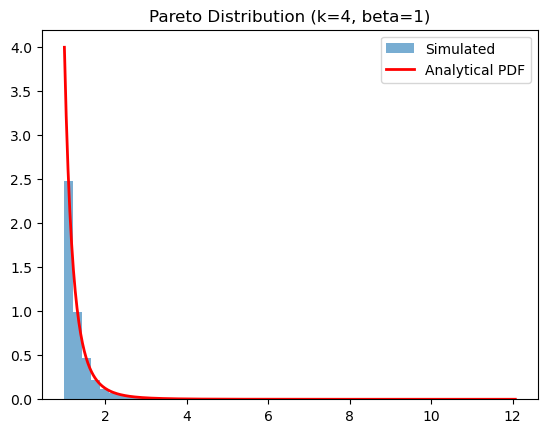

In [ ]:
k=4
samples = pareto_sample(10000, k=k, beta=1.0)
plot_histogram(samples, lambda x: pareto.pdf(x, b=k, scale=1),
                f"Pareto Distribution (k={k}, beta=1)")
